# Save the Dogs and Cats
Seeing how well we can predict the outcome for animals in Austin Shelter

In [1]:
#imports
import pandas as pd
import numpy as np
import datetime as dt
import time
import requests
import matplotlib.pyplot as plt
import string
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.preprocessing import StandardScaler
from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV
from scipy.stats import uniform, loguniform
from sklearn.neighbors import KNeighborsClassifier

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC



In [2]:
#Load in data
anim = pd.read_csv('../shelter-animal-outcomes/train.csv')

In [3]:
anim.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [4]:
anim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   AnimalID        26729 non-null  object
 1   Name            19038 non-null  object
 2   DateTime        26729 non-null  object
 3   OutcomeType     26729 non-null  object
 4   OutcomeSubtype  13117 non-null  object
 5   AnimalType      26729 non-null  object
 6   SexuponOutcome  26728 non-null  object
 7   AgeuponOutcome  26711 non-null  object
 8   Breed           26729 non-null  object
 9   Color           26729 non-null  object
dtypes: object(10)
memory usage: 2.0+ MB


In [5]:
#this gives away the ending
anim.drop(columns='OutcomeSubtype',inplace = True)

In [6]:
anim.drop(columns='Name',inplace = True)

In [7]:
#Change Dog/Cat to 0/1
anim['AnimalType'] = anim['AnimalType'].map(lambda x: 1 if x == 'Dog' else 0)

In [8]:
anim.head()

,AnimalID,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,2014-02-12 18:22:00,Return_to_owner,1,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,2013-10-13 12:44:00,Euthanasia,0,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,2015-01-31 12:28:00,Adoption,1,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,2014-07-11 19:09:00,Transfer,0,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,2013-11-15 12:52:00,Transfer,1,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [9]:
#Fill empties with the Unknown Category
anim['SexuponOutcome'].fillna('Unknown',inplace=True)

In [10]:
#Split the first part into whether is spayed or neutered
anim['spay'] = anim['SexuponOutcome'].map(lambda x: x.split()[0])

In [11]:
anim['spay'].value_counts()

Neutered    9779
Spayed      8820
Intact      7036
Unknown     1094
Name: spay, dtype: int64

In [12]:
#Combine spay/neuter difference since its redundant with gender
anim['spay'] = anim['spay'].map(lambda x: 'fixed' if x == 'Neutered' or x == 'Spayed' else x)

In [13]:
anim['spay'].value_counts()

fixed      18599
Intact      7036
Unknown     1094
Name: spay, dtype: int64

In [14]:
#dummify, want to drop unknown
anim = pd.get_dummies(anim,columns = ['spay'])

In [15]:
anim.drop(columns = 'spay_Unknown')

,AnimalID,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,spay_Intact,spay_fixed
0,A671945,2014-02-12 18:22:00,Return_to_owner,1,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,0,1
1,A656520,2013-10-13 12:44:00,Euthanasia,0,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,0,1
2,A686464,2015-01-31 12:28:00,Adoption,1,Neutered Male,2 years,Pit Bull Mix,Blue/White,0,1
3,A683430,2014-07-11 19:09:00,Transfer,0,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,1,0
4,A667013,2013-11-15 12:52:00,Transfer,1,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,0,1
...,...,...,...,...,...,...,...,...,...,...
26724,A702446,2015-05-14 11:56:00,Transfer,0,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White,1,0
26725,A718934,2016-01-20 18:59:00,Transfer,0,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby,0,1
26726,A698128,2015-03-09 13:33:00,Adoption,1,Neutered Male,4 years,Old English Bulldog Mix,White/Tan,0,1
26727,A677478,2014-04-27 12:22:00,Transfer,0,Intact Male,4 weeks,Domestic Shorthair Mix,Black,1,0


In [16]:
#This time doing the gender half, dummify and drop
anim['gender'] = anim['SexuponOutcome'].map(lambda x: x if x == 'Unknown' else x.split()[1])

In [17]:
anim['gender'].value_counts()

Male       13304
Female     12331
Unknown     1094
Name: gender, dtype: int64

In [18]:
anim.drop(columns='SexuponOutcome',inplace = True)

In [19]:
anim.head()

,AnimalID,DateTime,OutcomeType,AnimalType,AgeuponOutcome,Breed,Color,spay_Intact,spay_Unknown,spay_fixed,gender
0,A671945,2014-02-12 18:22:00,Return_to_owner,1,1 year,Shetland Sheepdog Mix,Brown/White,0,0,1,Male
1,A656520,2013-10-13 12:44:00,Euthanasia,0,1 year,Domestic Shorthair Mix,Cream Tabby,0,0,1,Female
2,A686464,2015-01-31 12:28:00,Adoption,1,2 years,Pit Bull Mix,Blue/White,0,0,1,Male
3,A683430,2014-07-11 19:09:00,Transfer,0,3 weeks,Domestic Shorthair Mix,Blue Cream,1,0,0,Male
4,A667013,2013-11-15 12:52:00,Transfer,1,2 years,Lhasa Apso/Miniature Poodle,Tan,0,0,1,Male


In [20]:
anim = pd.get_dummies(anim,columns = ['gender'])

In [21]:
anim.drop(columns = 'gender_Unknown',inplace = True)

In [22]:
anim.drop(columns = 'spay_Unknown',inplace = True)

In [23]:
anim.head()

,AnimalID,DateTime,OutcomeType,AnimalType,AgeuponOutcome,Breed,Color,spay_Intact,spay_fixed,gender_Female,gender_Male
0,A671945,2014-02-12 18:22:00,Return_to_owner,1,1 year,Shetland Sheepdog Mix,Brown/White,0,1,0,1
1,A656520,2013-10-13 12:44:00,Euthanasia,0,1 year,Domestic Shorthair Mix,Cream Tabby,0,1,1,0
2,A686464,2015-01-31 12:28:00,Adoption,1,2 years,Pit Bull Mix,Blue/White,0,1,0,1
3,A683430,2014-07-11 19:09:00,Transfer,0,3 weeks,Domestic Shorthair Mix,Blue Cream,1,0,0,1
4,A667013,2013-11-15 12:52:00,Transfer,1,2 years,Lhasa Apso/Miniature Poodle,Tan,0,1,0,1


In [24]:
#make date time to year, month, day, hour
anim['DateTime'] = pd.to_datetime(anim['DateTime'])
anim['year'] = pd.DatetimeIndex(anim['DateTime']).year
anim['month'] = pd.DatetimeIndex(anim['DateTime']).month
anim['day'] = pd.DatetimeIndex(anim['DateTime']).day
anim['hour'] = pd.DatetimeIndex(anim['DateTime']).hour
anim.drop(columns = 'DateTime',inplace = True)
anim.head()

,AnimalID,OutcomeType,AnimalType,AgeuponOutcome,Breed,Color,spay_Intact,spay_fixed,gender_Female,gender_Male,year,month,day,hour
0,A671945,Return_to_owner,1,1 year,Shetland Sheepdog Mix,Brown/White,0,1,0,1,2014,2,12,18
1,A656520,Euthanasia,0,1 year,Domestic Shorthair Mix,Cream Tabby,0,1,1,0,2013,10,13,12
2,A686464,Adoption,1,2 years,Pit Bull Mix,Blue/White,0,1,0,1,2015,1,31,12
3,A683430,Transfer,0,3 weeks,Domestic Shorthair Mix,Blue Cream,1,0,0,1,2014,7,11,19
4,A667013,Transfer,1,2 years,Lhasa Apso/Miniature Poodle,Tan,0,1,0,1,2013,11,15,12


In [25]:
#convert age to years, make take halfway between it and next interval (eg. 1 year = 365 + 180)
def agemath(x):
    try:
        if x.split()[1].startswith('day'):
            return int(x.split()[0])
        if x.split()[1].startswith('wee'):
            return int(x.split()[0])*7 + 3
        if x.split()[1].startswith('mont'):
            return int(x.split()[0])*30 + 15
        if x.split()[1].startswith('yea'):
            return int(x.split()[0])*365 + 180
    except:
        return np.nan
anim['Agedays'] = anim['AgeuponOutcome'].map(agemath)

In [26]:
anim['Agedays'].value_counts()

545.0     3969
910.0     3742
75.0      3397
1275.0    1823
45.0      1281
105.0     1277
1640.0    1071
2005.0     992
135.0      888
2370.0     670
24.0       659
165.0      652
195.0      588
3100.0     536
2735.0     531
17.0       529
315.0      457
3830.0     446
255.0      402
31.0       334
10.0       317
225.0      288
3465.0     288
4560.0     234
285.0      224
345.0      166
4925.0     143
4195.0     126
3.0        109
2.0         99
5290.0      97
5655.0      85
1.0         66
6.0         50
4.0         50
6020.0      36
5.0         24
180.0       22
6385.0      17
38.0        11
6750.0      10
7115.0       3
7480.0       2
Name: Agedays, dtype: int64

In [27]:
#fill with average
anim['Agedays'].fillna(anim['Agedays'].mean(),inplace = True)

In [28]:
anim['AgeuponOutcome'].value_counts()

1 year       3969
2 years      3742
2 months     3397
3 years      1823
1 month      1281
3 months     1277
4 years      1071
5 years       992
4 months      888
6 years       670
3 weeks       659
5 months      652
6 months      588
8 years       536
7 years       531
2 weeks       529
10 months     457
10 years      446
8 months      402
4 weeks       334
9 years       288
7 months      288
12 years      234
9 months      224
1 weeks       171
11 months     166
1 week        146
13 years      143
11 years      126
3 days        109
2 days         99
14 years       97
15 years       85
1 day          66
6 days         50
4 days         50
16 years       36
5 days         24
0 years        22
17 years       17
5 weeks        11
18 years       10
19 years        3
20 years        2
Name: AgeuponOutcome, dtype: int64

In [29]:
anim.head()

,AnimalID,OutcomeType,AnimalType,AgeuponOutcome,Breed,Color,spay_Intact,spay_fixed,gender_Female,gender_Male,year,month,day,hour,Agedays
0,A671945,Return_to_owner,1,1 year,Shetland Sheepdog Mix,Brown/White,0,1,0,1,2014,2,12,18,545.0
1,A656520,Euthanasia,0,1 year,Domestic Shorthair Mix,Cream Tabby,0,1,1,0,2013,10,13,12,545.0
2,A686464,Adoption,1,2 years,Pit Bull Mix,Blue/White,0,1,0,1,2015,1,31,12,910.0
3,A683430,Transfer,0,3 weeks,Domestic Shorthair Mix,Blue Cream,1,0,0,1,2014,7,11,19,24.0
4,A667013,Transfer,1,2 years,Lhasa Apso/Miniature Poodle,Tan,0,1,0,1,2013,11,15,12,910.0


In [30]:
#take primary animal color
anim['primary_col'] = anim['Color'].map(lambda x: x.split('/')[0].split()[0])

In [31]:
anim['primary_col'].value_counts()

Black        6646
Brown        5318
White        3344
Blue         2149
Tan          1674
Orange       1343
Red           871
Tricolor      800
Tortie        614
Calico        579
Cream         498
Chocolate     469
Torbie        398
Sable         324
Gray          278
Buff          267
Yellow        261
Fawn          209
Lynx          183
Seal          158
Silver         96
Flame          85
Gold           77
Lilac          39
Apricot        26
Liver          19
Agouti          2
Pink            1
Ruddy           1
Name: primary_col, dtype: int64

In [32]:
#make secondary color
def seccol(x):
    try:
        return x.split('/')[1].split()[0]
    except:
        return 'none'

anim['sec_col'] = anim['Color'].map(seccol)

In [33]:
anim['sec_col'].value_counts()

none         12805
White         8854
Black         1392
Brown         1381
Tan           1357
Blue           209
Gray           129
Red            120
Tricolor       112
Orange          97
Cream           80
Buff            61
Chocolate       50
Silver          26
Yellow          15
Liver           12
Gold             9
Calico           4
Apricot          4
Tortie           4
Lynx             3
Pink             3
Flame            1
Seal             1
Name: sec_col, dtype: int64

In [34]:
#make map of different pattern types

anim['tabby'] = anim['Color'].map(lambda x: 1 if 'Tabby' in x else 0)
anim['brindle'] = anim['Color'].map(lambda x: 1 if 'Brindle' in x else 0)
anim['point'] = anim['Color'].map(lambda x: 1 if 'Point' in x else 0)
anim['smoke'] = anim['Color'].map(lambda x: 1 if 'Smoke' in x else 0)
anim['tiger'] = anim['Color'].map(lambda x: 1 if 'Tiger' in x else 0)
anim['tick'] = anim['Color'].map(lambda x: 1 if 'Tick' in x else 0)
anim['merle'] = anim['Color'].map(lambda x: 1 if 'Merle' in x else 0)
anim['cream'] = anim['Color'].map(lambda x: 1 if 'Cream' in x else 0)


In [35]:
#mark mix breeds, list primary breed
anim['mix'] = anim['Breed'].map(lambda x: 1 if 'Mix' in x else 0)
anim['prim_breed'] = anim['Breed'].map(lambda x: x.split('/')[0].split(' Mix')[0])

In [36]:
#look to mark low multiplicity breeds as other
lowmult_breed = []
for i in range(len(anim.groupby('prim_breed').size())):
    if anim.groupby('prim_breed').size().sort_values()[i] < 50:
        lowmult_breed.append(anim.groupby('prim_breed').size().sort_values().index[i])
lowmult_breed

['Burmese',
 'Otterhound',
 'Ocicat',
 'Spinone Italiano',
 'Norwegian Forest Cat',
 'Norwegian Elkhound',
 'Swiss Hound',
 'Munchkin Longhair',
 'Mexican Hairless',
 'Cornish Rex',
 'Sealyham Terr',
 'Kuvasz',
 'Lowchen',
 'Spanish Mastiff',
 'English Cocker Spaniel',
 'Treeing Tennesse Brindle',
 'Havana Brown',
 'Entlebucher',
 'Afghan Hound',
 'Hovawart',
 'Port Water Dog',
 'Old English Sheepdog',
 'Wirehaired Pointing Griffon',
 'Devon Rex',
 'Javanese',
 'Field Spaniel',
 'Exotic Shorthair',
 'English Setter',
 'Cymric',
 'German Pinscher',
 'Neapolitan Mastiff',
 'Abyssinian',
 'Welsh Springer Spaniel',
 'Belgian Tervuren',
 'Unknown',
 'Turkish Van',
 'Bearded Collie',
 'Sphynx',
 'Belgian Sheepdog',
 'Nova Scotia Duck Tolling Retriever',
 'Bull Terrier Miniature',
 'Presa Canario',
 'Samoyed',
 'Picardy Sheepdog',
 'Jindo',
 'Bedlington Terr',
 'Japanese Chin',
 'English Foxhound',
 'English Shepherd',
 'Irish Setter',
 'Ibizan Hound',
 'Old English Bulldog',
 'Pixiebob Short

In [37]:
anim['red_breeds'] = anim['Breed'].map(lambda x: x.split(' Mix')[0] if x not in lowmult_breed else 'other')

In [38]:
anim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AnimalID        26729 non-null  object 
 1   OutcomeType     26729 non-null  object 
 2   AnimalType      26729 non-null  int64  
 3   AgeuponOutcome  26711 non-null  object 
 4   Breed           26729 non-null  object 
 5   Color           26729 non-null  object 
 6   spay_Intact     26729 non-null  uint8  
 7   spay_fixed      26729 non-null  uint8  
 8   gender_Female   26729 non-null  uint8  
 9   gender_Male     26729 non-null  uint8  
 10  year            26729 non-null  int64  
 11  month           26729 non-null  int64  
 12  day             26729 non-null  int64  
 13  hour            26729 non-null  int64  
 14  Agedays         26729 non-null  float64
 15  primary_col     26729 non-null  object 
 16  sec_col         26729 non-null  object 
 17  tabby           26729 non-null 

In [39]:
#dummify a lot
anim = pd.get_dummies(anim,columns=['prim_breed'],drop_first = True)

In [40]:
anim = pd.get_dummies(anim,columns=['red_breeds'],drop_first = True)

In [41]:
anim = pd.get_dummies(anim,columns=['primary_col'],drop_first = True)

In [42]:
anim = pd.get_dummies(anim,columns=['sec_col'],drop_first = True)

In [43]:
#make possible lists to change X in fits
patterns = ['tabby','brindle','point','smoke','tiger','tick','merle','cream']
prim_breed_list = []
red_breed_list = []
for i in anim.columns:
    if i.startswith('prim_breed'):
        prim_breed_list.append(i)
    if i.startswith('red_breeds'):
        red_breed_list.append(i)
    


In [44]:
#save
anim.to_csv('../data_out/animals_somewhatcleaned.csv')

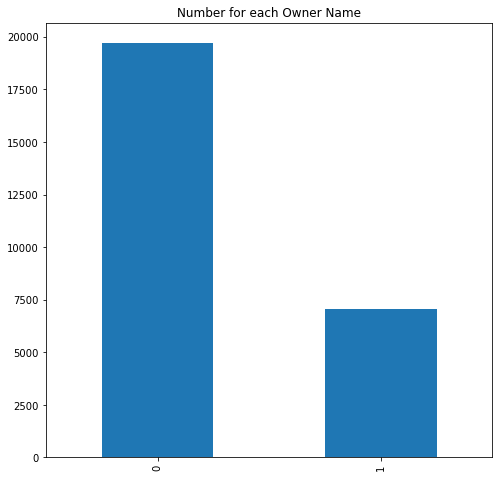

In [62]:
x = anim['spay_Intact'].value_counts().plot(kind='bar',
                                    figsize=(8,8),
                                    title="Number for each Owner Name")

<AxesSubplot:title={'center':'Number for each Owner Name'}>

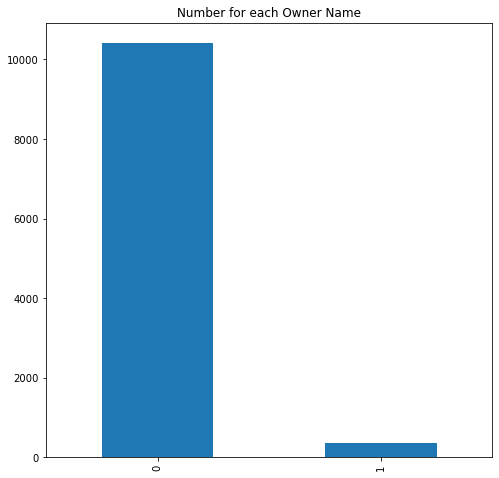

In [66]:
x = anim[anim['OutcomeType']=='Adoption']['spay_Intact'].value_counts().plot(kind='bar',
                                    figsize=(8,8),
                                    title="Number for each Owner Name")
x

<AxesSubplot:title={'center':'Number for each Owner Name'}>

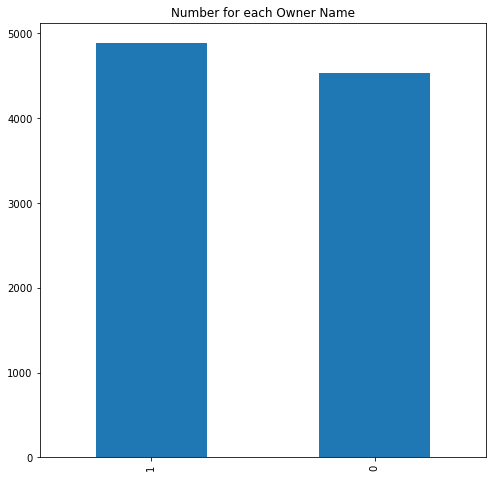

In [68]:
x = anim[anim['OutcomeType']=='Transfer']['spay_Intact'].value_counts().plot(kind='bar',
                                    figsize=(8,8),
                                    title="Number for each Owner Name")
x

<AxesSubplot:title={'center':'Number for each Owner Name'}>

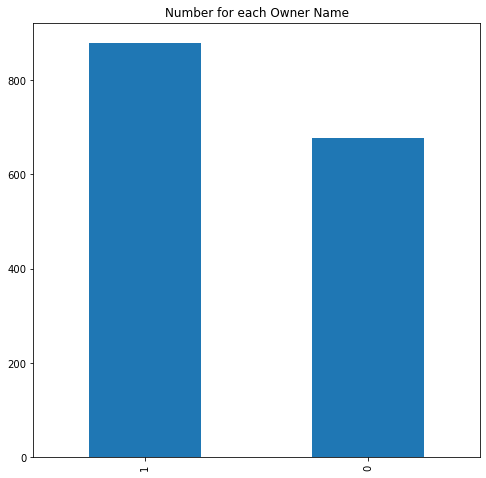

In [69]:
x = anim[anim['OutcomeType']=='Euthanasia']['spay_Intact'].value_counts().plot(kind='bar',
                                    figsize=(8,8),
                                    title="Number for each Owner Name")
x

In [45]:
#train test split, removing red_breed_list did well
X = anim.drop(columns=['AnimalID','OutcomeType','AgeuponOutcome','Breed','Color']+red_breed_list)
y = anim['OutcomeType']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [46]:
#make something to just out put what we want to see
def metrics_output(model,xtrain,ytrain,xtest,ytest):
    print(f'Train Accuracy: %0.4f\tTest Accuracy: %0.4f' %(model.score(xtrain,ytrain),model.score(xtest,ytest)))
    model_probs = model.predict_proba(X_test)
    print(f'Multiclass Loss: %0.4f' % (metrics.log_loss(ytest,model_probs)))
    try:
        print('Params ',model.best_params_)
    except:
        pass

In [47]:
def metrics_loss(model,xtrain,ytrain,xtest,ytest):
    model_probs = model.predict_proba(X_test)
    print(f'Train Accuracy: %0.4f\tTest Accuracy: %0.4f' %(metrics.accuracy_score(y_train,model.predict(X_train)),metrics.accuracy_score(y_test,model.predict(X_test))))
    print(f'Multiclass Loss: %0.4f' % (metrics.log_loss(y_test,model_probs)))
    try:
        print('Params ',model.best_params_)
    except:
        pass

In [48]:
# lr = LogisticRegression(random_state=42,penalty = 'none',max_iter = 100000,
#                               solver = 'sag')
# lr.fit(X_train,y_train)

In [49]:
# lr.score(X_train,y_train),lr.score(X_test,y_test)

In [50]:
# clf_probs = lr.predict_proba(X_test)
# metrics.log_loss(y_test,clf_probs)

In [51]:
y.value_counts(normalize = True)

Adoption           0.402896
Transfer           0.352501
Return_to_owner    0.179056
Euthanasia         0.058177
Died               0.007370
Name: OutcomeType, dtype: float64

In [52]:
plt.figure(figsize = (12,8))
corr =anim.corr()
corr
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data = corr,
           annot = True,
            vmin = -1,
            vmax = 1,
           mask = mask,
           cmap = 'viridis_r');

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002020AC42790> (for post_execute):


KeyboardInterrupt: 

In [52]:
#random forest
gsrf_pipe = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])
gsrf_params={'rf__n_estimators': [300],
             'rf__max_depth': [20,30,40],
             'rf__min_samples_split': [2,3,4,5],
             'rf__min_samples_leaf': [1,2,3],
             'rf__max_features': ['auto']
            }

In [53]:
gsrf = GridSearchCV(gsrf_pipe,gsrf_params,cv =5,n_jobs = -1,verbose =10)
gsrf.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 176 out of 180 | elapsed:  7.6min remaining:   10.3s
[Parallel(n_jobs=-1)]: Done 180 out 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [20, 30, 40],
                         'rf__max_features': ['auto'],
                         'rf__min_samples_leaf': [1, 2, 3],
                         'rf__min_samples_split': [2, 3, 4, 5],
                         'rf__n_estimators': [300]},
             verbose=10)

In [54]:
metrics_output(gsrf,X_train,y_train,X_test,y_test)

Train Accuracy: 0.9533	Test Accuracy: 0.6515
Multiclass Loss: 0.8605
Params  {'rf__max_depth': 40, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 4, 'rf__n_estimators': 300}


In [55]:
#decision tree
gsdt_pipe = Pipeline([
    ('dt', DecisionTreeClassifier(random_state=42))
])
gsdt_params = {
             'dt__max_depth': [20,25,30,35,40,45,60],
             'dt__min_samples_split': [5, 10, 15, 20, 25, 30, 35,40,45,50],
             'dt__min_samples_leaf': [1,2],
}
gsdt = GridSearchCV(gsdt_pipe,gsdt_params,cv =5,verbose = 10,n_jobs = -1)
gsdt.fit(X_train,y_train)



Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'dt__max_depth': [20, 25, 30, 35, 40, 45, 60],
                         'dt__min_samples_leaf': [1, 2],
                         'dt__min_samples_split': [5, 10, 15, 20, 25, 30, 35,
                                                   40, 45, 50]},
             verbose=10)

In [56]:
metrics_output(gsdt,X_train,y_train,X_test,y_test)

Train Accuracy: 0.7140	Test Accuracy: 0.6337
Multiclass Loss: 2.1177
Params  {'dt__max_depth': 20, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 50}


In [57]:
# nb = MultinomialNB()
# nb.fit(X_train,y_train)

In [58]:
#try with red_breed instead o
X = anim.drop(columns=['AnimalID','OutcomeType','AgeuponOutcome','Breed','Color']+prim_breed_list)
y = anim['OutcomeType']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [59]:
gsrf_pipe = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])
gsrf_params={'rf__n_estimators': [300],
             'rf__max_depth': [20,30,40],
             'rf__min_samples_split': [2,3,4,5],
             'rf__min_samples_leaf': [1,2,3],
             'rf__max_features': ['auto']
            }

In [60]:
gsrf = GridSearchCV(gsrf_pipe,gsrf_params,cv =5,n_jobs = -1,verbose =10)
gsrf.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 176 out of 180 | elapsed: 14.8min remaining:   20.1s
[Parallel(n_jobs=-1)]: Done 180 out 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [20, 30, 40],
                         'rf__max_features': ['auto'],
                         'rf__min_samples_leaf': [1, 2, 3],
                         'rf__min_samples_split': [2, 3, 4, 5],
                         'rf__n_estimators': [300]},
             verbose=10)

In [61]:
metrics_output(gsrf,X_train,y_train,X_test,y_test)

Train Accuracy: 0.9091	Test Accuracy: 0.6427
Multiclass Loss: 0.8669
Params  {'rf__max_depth': 40, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 3, 'rf__n_estimators': 300}


In [62]:
gsdt_pipe = Pipeline([
    ('dt', DecisionTreeClassifier(random_state=42))
])
gsdt_params = {
             'dt__max_depth': [20,25,30,35,40,45,60],
             'dt__min_samples_split': [5, 10, 15, 20, 25, 30, 35,40,45,50],
             'dt__min_samples_leaf': [1,2],
}
gsdt = GridSearchCV(gsdt_pipe,gsdt_params,cv =5,verbose = 10,n_jobs = -1)
gsdt.fit(X_train,y_train)



Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'dt__max_depth': [20, 25, 30, 35, 40, 45, 60],
                         'dt__min_samples_leaf': [1, 2],
                         'dt__min_samples_split': [5, 10, 15, 20, 25, 30, 35,
                                                   40, 45, 50]},
             verbose=10)

In [63]:
metrics_output(gsdt,X_train,y_train,X_test,y_test)

Train Accuracy: 0.7138	Test Accuracy: 0.6388
Multiclass Loss: 2.1228
Params  {'dt__max_depth': 20, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 50}


In [54]:
X = anim.drop(columns=['AnimalID','OutcomeType','AgeuponOutcome','Breed','Color']+red_breed_list)
y = anim['OutcomeType']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [55]:
ss = StandardScaler()
Ztrain = ss.fit_transform(X_train,y_train)
Ztest = ss.transform(X_test)

In [58]:
lr = LogisticRegressionCV(random_state=42,penalty = 'l1',max_iter = 100000,
                              solver = 'liblinear',Cs=np.logspace(-5,5,21), 
                              cv = 5,n_jobs = -1,verbose = 10,scoring = 'neg_log_loss')

In [ ]:
lr.fit(Ztrain,y_train)
metrics_output(lr,Ztrain,y_train,Ztest,y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


In [49]:
lr = LogisticRegression(random_state=42,penalty = 'none',max_iter = 100000,
                              solver = 'sag',n_jobs = -1)
lr.fit(X_train,y_train)
metrics_output(lr,X_train,y_train,X_test,y_test)

Train Accuracy: 0.6125	Test Accuracy: 0.6128
Multiclass Loss: 0.9825


AttributeError: 'LogisticRegression' object has no attribute 'best_params_'

In [54]:
gsknn_pipe = Pipeline([
    ('knn', KNeighborsClassifier())
])
gsknn_params = {
    'knn__n_neighbors': [3,5,7,11,15]         
}
gsknn = GridSearchCV(gsknn_pipe,gsknn_params,cv =5,verbose = 10,n_jobs = -1)
gsknn.fit(Ztrain,y_train)
metrics_output(gsknn,Ztrain,y_train,Ztest,y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:  1.1min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:  1.1min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:  1.1min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:  2.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:  2.2min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:  2.2min remaining:   32.5s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:  2.2min remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.6min finished


Train Accuracy: 0.6269	Test Accuracy: 0.5802
Multiclass Loss: 1.8964
Params  {'knn__n_neighbors': 15}


In [63]:
rssv_pipe = Pipeline([
    ('ss',StandardScaler()),
    ('svc', SVC(random_state = 42))
])

rssv_params = {
    'svc__C': loguniform(1e-5,1e+2), # was: np.logspace(-5,2, 10),
    'svc__kernel': ['poly','rbf'],
    'svc__gamma': ['scale','auto'],
    'svc__degree': list(np.linspace(2,10,9)), # same as before because we need integers
    'svc__coef0': uniform(0,1), # was: np.linspace(0,1, 5),
    'svc__shrinking': [True, False]   
}

rssv = RandomizedSearchCV(estimator = rssv_pipe,
                     param_distributions = rssv_params,
                     scoring = 'neg_log_loss',
                     n_iter = 2000,
                     n_jobs = -1,
                     cv = 5,
                     verbose = 10)

In [ ]:
rssv.fit(X_train,y_train)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [49]:
svec = SVC(random_state = 42)
svec.fit(Ztrain, y_train)

SVC(random_state=42)

In [51]:
metrics_output(svec,Ztrain,y_train,Ztest,y_test)

Train Accuracy: 0.6453	Test Accuracy: 0.6218


AttributeError: predict_proba is not available when  probability=False

# This is the best result we were able to obtain
Random forest using neg_log_loss scoring. A little bit better than the other random forest with wider parameter set (other one was honed to its values) and using desired scoring

In [52]:
gsrf_pipe = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])
gsrf_params={'rf__n_estimators': [150,200,250,300,350,400,450],
             'rf__max_depth': [30,40,50],
             'rf__min_samples_split': [3,4,5],
             'rf__min_samples_leaf': [1],
             'rf__max_features': ['auto']
            }
gsrf = GridSearchCV(gsrf_pipe,gsrf_params,cv =5,n_jobs = -1,verbose =10,scoring='neg_log_loss')

In [53]:
gsrf.fit(X_train,y_train)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [30, 40, 50],
                         'rf__max_features': ['auto'],
                         'rf__min_samples_leaf': [1],
                         'rf__min_samples_split': [3, 4, 5],
                         'rf__n_estimators': [150, 200, 250, 300, 350, 400,
                                              450]},
             scoring='neg_log_loss', verbose=10)

In [54]:
metrics_output(gsrf,X_train,y_train,X_test,y_test)

Train Accuracy: -0.4372	Test Accuracy: -0.8462
Multiclass Loss: 0.8462
Params  {'rf__max_depth': 30, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 3, 'rf__n_estimators': 400}


In [57]:
gsrf_probs = gsrf.predict_proba(X_test)
print(f'Train Accuracy: %0.4f\tTest Accuracy: %0.4f' %(metrics.accuracy_score(y_train,gsrf.predict(X_train)),metrics.accuracy_score(y_test,gsrf.predict(X_test))))
print(f'Multiclass Loss: %0.4f' % (metrics.log_loss(y_test,gsrf_probs)))

Train Accuracy: 0.9231	Test Accuracy: 0.6496
Multiclass Loss: 0.8462


In [55]:
# gssv_pipe = Pipeline([
#     ('ss',StandardScaler()),
#     ('svc', SVC(random_state = 42))
# ])

# gssv_params = {
#     'svc__C': np.logspace(-5,2, 8),
#     'svc__kernel': ['linear','rbf'],
# }

# gssv = GridSearchCV(gssv_pipe,gssv_params,
#                      scoring = 'neg_log_loss',
#                      n_jobs = -1,
#                      cv = 5,
#                      verbose = 10)

In [56]:
gsknn_pipe = Pipeline([
    ('knn', KNeighborsClassifier())
])
gsknn_params = {
    'knn__n_neighbors': [3,5,7,11,15]         
}
gsknn = GridSearchCV(gsknn_pipe,gsknn_params,cv =5,verbose = 10,n_jobs = -1,scoring='neg_log_loss')
gsknn.fit(Ztrain,y_train)
metrics_loss(gsknn,Ztrain,y_train,Ztest,y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:   59.3s remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:   59.8s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:  1.0min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:  1.9min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:  2.0min remaining:   56.0s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:  2.0min remaining:   29.8s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:  2.0min remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.4min finished


Train Accuracy: 0.1833	Test Accuracy: 0.1867
Multiclass Loss: 1.8964
Params  {'knn__n_neighbors': 15}


In [53]:
gsrf_pipe = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])
gsrf_params={'rf__max_depth': [30], 'rf__max_features': ['auto'], 
             'rf__min_samples_leaf': [1], 'rf__min_samples_split': [3], 
             'rf__n_estimators': [400]
            }
gsrf = GridSearchCV(gsrf_pipe,gsrf_params,cv =5,n_jobs = -1,verbose =10,scoring='neg_log_loss')
gsrf.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   22.8s remaining:   34.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   22.8s remaining:   15.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.9s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [30], 'rf__max_features': ['auto'],
                         'rf__min_samples_leaf': [1],
                         'rf__min_samples_split': [3],
                         'rf__n_estimators': [400]},
             scoring='neg_log_loss', verbose=10)

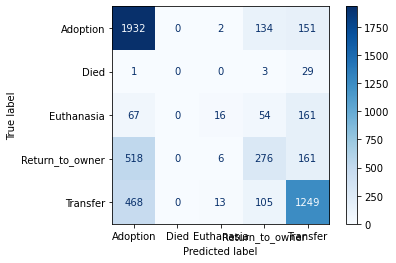

In [58]:
plot_confusion_matrix(gsrf, X_test, y_test, cmap='Blues')